In [1]:
#! /usr/bin/env python3
import importlib
import inspect
import pprint
import os
from pathlib import Path
#
from Pegasus.api import *
pegasus_graphviz = importlib.import_module("pegasus-graphviz")

import graphviz as graphviz
import pygraphviz as pgv
from IPython.display import Image
from IPython.display import IFrame
from wand.image import Image as WImage

# splinter
import subprocess
import time
import concurrent.futures

#
import yaml as yaml
import pydot as pydot

import itertools
import copy
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

import ast
from PIL import ImageColor
import ipyplot

from pprint import pprint
from IPython.core.debugger import set_trace

import logging

#logging.basicConfig(level=logging.INFO)

BINARY_PATH  ='/home/scitech/shared-data/maestro-test/binaries/'
MOCKTAGE_PATH='/home/scitech/mocktage/build/bin/'
DATA_PATH    ='/home/scitech/shared-data/maestro-test/binaries/data/'
SCRATCH_PATH ='/home/scitech/scratch/'

In [2]:
def build_transformation_catalog(wf):
    
    tc = TransformationCatalog()
    trans = {}

    exes = {}
    binary_paths = [BINARY_PATH, MOCKTAGE_PATH]
    
    for base in binary_paths:
        base_dir = os.path.dirname(base)

        for fname in os.listdir(base_dir):
            #print('Making Transformation for', fname)
            transformation = None
            if fname[0] == '.':
                continue

            transformation = Transformation(fname, 
                                            site='local',
                                            pfn=os.path.join(base_dir, fname), 
                                            is_stageable=True)
            transformation.add_env(PATH='/usr/bin:/bin:.')

            # memory requirement
            transformation.add_profiles(Namespace.CONDOR, 'request_memory', '1 GB')

            # some transformations can be clustered for effiency
            #if fname in ['gmProject', 'mDiff', 'mDiffFit', 'mBackground']:
            #    transformation.add_profiles(Namespace.PEGASUS, 'clusters.size', '3')

            # keep a handle to added ones, for use later
            trans[fname] = transformation

            tc.add_transformations(transformation)

    wf.add_transformation_catalog(tc)


In [3]:
def build_site_catalog():
    # create a SiteCatalog object
    sc = SiteCatalog()

    # -----------------------------------------------
    # create a "local" site
    local = Site("local", arch=Arch.X86_64, os_type=OS.LINUX)

    #pprint(dir(Directory))
    # create and add a shared scratch and local storage directories to the site "local"
    local_shared_scratch_dir = Directory(Directory.SHARED_SCRATCH, path=SCRATCH_PATH)\
        .add_file_servers(FileServer("file://" + SCRATCH_PATH, Operation.ALL))

    #local_local_storage_dir = Directory(Directory.LOCAL_STORAGE, path="/tmp/pegasus/local")\
    #                            .add_file_servers(FileServer("file:///tmp/pegasus/local", Operation.ALL))
    local_shared_binary_dir = Directory(Directory.LOCAL_STORAGE, path=BINARY_PATH)\
        .add_file_servers(FileServer("file://" + BINARY_PATH, Operation.ALL))
    local_shared_binary_dir = Directory(Directory.LOCAL_STORAGE, path=MOCKTAGE_PATH)\
        .add_file_servers(FileServer("file://" + MOCKTAGE_PATH, Operation.ALL))

    local.add_directories(local_shared_scratch_dir, local_shared_binary_dir)

    
    # -----------------------------------------------
    # create a "condorpool" site
    condorpool = Site("condorpool")\
                    .add_pegasus_profile(style="condor")\
                    .add_pegasus_profile(auxillary_local="true")\
                    .add_condor_profile(universe="local")

    # create and add a shared scratch directory to the site "condorpool"
    condorpool_shared_scratch_dir = Directory(Directory.SHARED_SCRATCH, path=SCRATCH_PATH)\
        .add_file_servers(FileServer("file://" + SCRATCH_PATH, Operation.ALL))
#     condorpool_local_storage_dir = Directory(Directory.LOCAL_STORAGE, path=SCRATCH_PATH)\
#         .add_file_servers(FileServer("file://" + SCRATCH_PATH, Operation.ALL))
    condorpool_shared_binary_dir = Directory(Directory.LOCAL_STORAGE, path=BINARY_PATH)\
        .add_file_servers(FileServer("file://" + BINARY_PATH, Operation.ALL))
    condorpool_shared_binary_dir = Directory(Directory.LOCAL_STORAGE, path=MOCKTAGE_PATH)\
        .add_file_servers(FileServer("file://" + MOCKTAGE_PATH, Operation.ALL))
    
    condorpool.add_directories(condorpool_shared_scratch_dir, condorpool_shared_binary_dir)

    # -----------------------------------------------                
    # add the sites to the site catalog object
    sc.add_sites(local, condorpool)

    # write the site catalog to the default path "./sites.yml"
    #set_trace()
    sc.write()
    
    return sc

In [4]:
def build_properties():
    props = Properties() 
    #props["pegasus.mode"] = "development"
    #props["pegasus.data.configuration"] = "sharedfs"
    #props["pegasus.code.generator"] = "Shell"
    props.write()
    return props

In [5]:
LOG_LEVEL = "0"
        
global_component_id = 0

def next_id_string(): 
    global global_component_id
    temp = global_component_id
    global_component_id += 1
    return 'ID-' + str(temp)

def cdo_name(file):
    return file # 'CDO-' + file

In [6]:
class task:
    _task_id = -1
    _command = "ls -1"
    _dependent_task_array = []
    _provider_task_array = []

    def __init__(self, task_id, command, dependent_task_array):
        self._task_id = task_id
        self._command = command
        self._dependent_task_array = dependent_task_array

    def dependent_task_array(self):
        return self._dependent_task_array

    def command(self):
        return self._command

    def task_id(self):
        return self._task_id


class task_status:
    _task = None
    _future = None

    def __init__(self, task, future):
        self._future = future
        self._task = task

    def future(self):
        return self._future

    def task(self):
        return self._task


class splinter_workflow:
    _task_array = []
    _pending_task_array = []
    _completed_task_array = []
    _task_status_array = []
    _njob = 0

    def add_task(self, task):
        self._task_array.append(task)

    def find_next_task(self):
        n_pending_task = len(self._pending_task_array)
        if n_pending_task != 0:
            for i in range(0, n_pending_task):
                if self.are_task_dependencies_satisfied(self._pending_task_array[i]):
                    return self._pending_task_array[i]
        return None

    def completed_task_status(self):
        for task_status in self._task_status_array:
            if task_status.future().done():
                return task_status
        return None

    def is_workflow_active(self):
        if len(self._pending_task_array) != 0:
            return True

        if len(self._task_status_array) != 0:
            return True

        return False

    def are_task_dependencies_satisfied(self, task):
        # race? : if a task completes whilst we are iterating this list?
        completed_task_id_array = [task.task_id() for task in self._completed_task_array]
        pending_task_id_array = [task.task_id() for task in self._pending_task_array]
        # for every parent of this task
        for dependent_task in task.dependent_task_array():
            # if a parent task isn't marked as completed, we cannot run
            if not dependent_task in completed_task_id_array:
                return False
            # if a parent task has not run yet, we cannot run
            if dependent_task in pending_task_id_array:
                return False
        return True

    def is_worker_available(self):
        if len(self._task_status_array) < self._njob:
            return True
        return False

    def execute_workflow(self, njob, poll_frequency):
        self._pending_task_array = self._task_array
        self._njob = njob

        with concurrent.futures.ThreadPoolExecutor(max_workers=njob) as executor:
            poll_loop = 0
            while self.is_workflow_active():
                print()
                completed_task_id_array = [task.task_id() for task in self._completed_task_array]
                pending_task_id_array = [task.task_id() for task in self._pending_task_array]
                print('Poll loop', poll_loop, ' : Completed tasks', completed_task_id_array,
                    ' : Pending tasks', pending_task_id_array)
                if self.is_worker_available():
                    # Launch as many tasks as possible in each polling window
                    task = self.find_next_task()
                    while task is not None:
                        self._pending_task_array.remove(task)
                        print("Submitting Job", task.task_id(), task.command())
                        future = executor.submit(subprocess.run, task.command(), stdout=subprocess.PIPE)
                        self._task_status_array.append(task_status(task, future))
                        # any more tasks ready to execute
                        task = self.find_next_task()

                # Clear as many tasks as possible in each polling window
                completed_task_status = self.completed_task_status()                        
                while completed_task_status is not None:
                    print("Job Completed", completed_task_status.task().task_id())
                    self._completed_task_array.append(
                        completed_task_status.task())
                    self._task_status_array.remove(completed_task_status)
                    # any more completed tasks?
                    completed_task_status = self.completed_task_status()                        

                time.sleep(poll_frequency)
                poll_loop += 1

In [7]:
class CDO:
    def __init__(self, filename: str):
        self.filename    = filename
        self.cached_name = 'cdo-cache-' + filename
        self.input_count = 0
        self.cache       = None

# -----------------------------------------------------------
# Define a subclass of the pegasus workflow object 
#
# Override pegasus job insertion, to customize for CDOs
#
class Maestro_Workflow(Workflow):
    
    def __init__(self, cdo_dependency, name: str, infer_dependencies: bool = True):
        print("This is the init function")
        super().__init__(name, infer_dependencies)
        self.parent_tasks = {}
        self.cdo_dependency = cdo_dependency
        self.pool_manager = Job("start-pool-manager.sh", node_label="pool-manager")\
                            .add_args(SCRATCH_PATH, "pool_manager.stop", MOCKTAGE_PATH + "/pool_manager", SCRATCH_PATH + "/pminfo") \
                            .add_metadata(maestro_workflow_core_backend="minio", cdo_poolmanager='true')
        super().add_jobs(self.pool_manager)
        # .add_outputs(File("pool_io"))\

    # find the input to a job that generates the named output
    def find_parent_dependency(self, output):
        for id, job in self.jobs.items():
            # if this output matches the request, find the first input
            for op in job.get_outputs():
                #print('testing', op.lfn, 'against',output)
                if op.lfn == output and len(job.get_inputs())>0:
                    # just get the filename of the first input
                    temp = next(iter(job.get_inputs())).lfn
                    #print('Found a match using', temp)                    
                    return next(iter(job.get_inputs())).lfn
        print('No parent for', output)
        return output

    def is_watcher(self, job):
        return ('cdo_watcher' in job.metadata)
    
    def is_cache(self, job):
        return ('cdo_cache' in job.metadata)
    
    #
    # This is the main routine that walks the graph and converts files to CDOs
    # inserts watchers and cache objects.
    #
    def insert_cdo_jobs(self):        
        # Show input output file objects to see which are shared objects
        # for debugging only
        if False:
            for id, job in self.jobs.items():
                for u in job.uses:
                    #print(object.__repr__(u.file), u.file.lfn)
                    ...
                for ip in job.get_inputs():
                    #print('Input', ip, ip.lfn)
                    ...
                for op in job.get_outputs():
                    #print('Output', op, op.lfn)
                    ...
        
        # note that we must rename input and outputs using new file objects
        # to work around shared files that are both input and outputs
        # and are replaced by CDO objects
        i_replacements = {}
        o_replacements = {}
        
        # store watchers created to prevent creating 2 watchers for the same CDO
        # if it is consumed by more than one process
        watchers   = {}
        cdo_objs   = {}
        extra_jobs = []
        for id, job in self.jobs.items():                
            # For each input :      in -> P -> out
            #   replace with parent(in) -> watcher ->
            #                                   -> (in)' -> P -> out
            if len(job.get_inputs())>0:
                for ip in job.get_inputs():
                    cdo_enabled = True
                    if "cdo_disabled" in ip.metadata:
                        cdo_enabled = not ip.metadata['cdo_disabled'].lower() in ['true', '1', 't', 'y', 'yes']                    
                        #print(ip, "is cdo enabled", cdo_enabled)
                    if not cdo_enabled:
                        print('No substitution for non CDO enabled input', ip.lfn)
                        continue
                    
                    ip_name        = ip.lfn
                    trigger_name   = 'T-' + ip_name
                    node_label     = '' + ip_name
                    cache_label    = '' + ip_name
                    
                    # track how many consumers are taking this CDO as an input
                    if not ip_name in cdo_objs:
                        
                        cdo_objs[ip_name] = CDO(ip.lfn)
                        cdo_objs[ip_name].input_count = 1
                        
                        # if multiple processes consume the same CDO, we only need one watcher
                        # create a watcher for this CDO input
                        id_string = next_id_string()
                        watcher = Job("process-CDO", node_label = id_string)
                        pseudo_parent = self.find_parent_dependency(ip_name)
                        watcher.add_env(MSTRO_LOG_LEVEL=LOG_LEVEL)
                        watcher.add_inputs(pseudo_parent)
                        watcher.add_outputs(File(trigger_name).add_metadata(dummy_file='true'), stage_out=True)
                        watcher.add_args('-l', SCRATCH_PATH,     # log directory 
                                         '-p', 'pminfo',         # pool manager info
                                         '-t', trigger_name,     # trigger_file for pegasus
                                         '-c', id_string,        # component name, must be unique
                                         '-i', ip_name)          # list of input CDOs to consume
                        watcher.add_metadata(cdo_watcher='true')
                        watchers[node_label] = watcher
                        
                        id_string = next_id_string()
                        #cache_label = id_string # REMOVE AFTER DEBUGGING
                        cache = Job("process-CDO", node_label = id_string) # cache_label)
                        cache.add_env(MSTRO_LOG_LEVEL=LOG_LEVEL)
                        cache.add_inputs(pseudo_parent) 
                        cache.add_args('-l', SCRATCH_PATH,     # log directory 
                                       '-p', 'pminfo',         # pool manager info
                                       '-c', id_string,        # component name, must be unique
                                       '-g',                   # stager mode, copies in to out (cache)
                                       '-i', ip_name)          # list of input CDOs to consume
                        cache.add_metadata(cdo_cache='true')

                        # add the cache object for lookup later
                        cdo_objs[ip_name].cache = cache
                        
                        # Add these new jobs to the actual DAG
                        extra_jobs.append(watcher)
                        extra_jobs.append(cache)
                        
                    else:
                        print('Adding to', ip_name) 
                        cdo_objs[ip_name].input_count += 1
                        
                    # any process that outputs this data will need to rename it to the new input name
                    o_replacements[ip_name] = ip_name
                    
                    # for dependencies that use files as input : rename it to the new trigger file name 
                    i_replacements[ip_name] = trigger_name
                
            if "final_job" in job.metadata:
                print ('final job', id, 'corresponds to', job.node_label)
                newjob = Job("stop-pool-manager.sh", node_label="stop-pool-manager")
                newjob.add_args(SCRATCH_PATH, 'pool_manager.stop') \
                    .add_metadata(cdo_poolmanager='true')
                for op in job.get_outputs():
                    newjob.add_inputs(op.lfn)
                extra_jobs.append(newjob)

        for job in extra_jobs:
            if job._id is None:
                job._id = self._get_next_job_id()
            self.jobs[job._id] = job
        
        # when we replace an input to a job with a CDO version of it, we have to create a new "File" object
        # because if we simply change the path/name, we might modify the same 'file' object on different 
        # jobs and we can get links between tasks we were not expecting
        for id, job in self.jobs.items():
            for u in job.uses:
                if u.file.lfn in i_replacements:
                    # Replace an input that we have changed to point to the dummy file
                    if u._type == "input":
                        u.file = File(i_replacements[u.file.lfn]).add_metadata(dummy_file='true')
                    # Replace an output that we have changed to point to the CDO
                    if u._type == "output":
                        # we add a watcher and a cache as dependencies of this CDO
                        job.add_args('-O', '2')
                        # make sure the CDO cache is kept alive for N real consumers
                        cdo_objs[u.file.lfn].cache.add_args('-O', cdo_objs[u.file.lfn].input_count)
                        if u.file.lfn in cdo_objs:
                            if self.cdo_dependency :
                                u.file = File(o_replacements[u.file.lfn]).add_metadata(cdo_data='true') 
                            else:
                                u.file = None
            job.uses = [x for x in job.uses if x.file is not None]
                                    
        print('Substitution of command line filenames for cached CDOs')
        for id, job in self.jobs.items():
            # watchers always watch for the original CDO (no name change)
            # cache's will output a CDO with a new name (name change handled by cache itself)
            # other objects must rename their inbput file/cdo names to the renamed version
            if self.is_watcher(job) or self.is_cache(job):
                ...
            else:
                new_args = []
                # we must only change input CDO names, as original output names go into the cache 
                input = False
                for a in job.args:
                    if a == '-i':
                        input = True
                    if a == '-o':
                        input = False
                    if input and isinstance(a, File):
                        cdo_name = 'cdo-cache-' + a.lfn
                        a = File(cdo_name)
                    new_args.append(a)
                job.args = new_args
            #
            print(job.args)
                    
        for d, val in self.dependencies.items():
            print('Dependency', d, val)

            
    def execute_using_slurm(self):
        return        
    
    def build_dependencies(self):
        # buiod list of children for each task
        self.infer_dependencies = True
        self._infer_dependencies()
        
        # construct list of parents from child list
        for k,v in self.dependencies.items():
            for c in v.children_ids:
                if c in self.parent_tasks:
                    self.parent_tasks[c] = self.parent_tasks[c] + [k]
                else:
                    self.parent_tasks[c] = [k]
                    
        for task, parent in self.parent_tasks.items():
            #print('Task', task, 'Depends on', parent)
            ...
        return
        
    def execute_using_splinter(self):
        # get the transformation catalog
        #print(dir(self.transformation_catalog))
        tc = self.transformation_catalog.transformations        
        # for x in tc:
        #     print (x)
            
        # build parent/child dependency lists 
        self.build_dependencies()
        # create a splinter workflow
        swf = splinter_workflow()
        
        for id, job in self.jobs.items():
            t_string = "None::" + job.transformation + "::None"
            t_path = tc[t_string].sites['local'].pfn            
            # convert any file objects to string pathnames in arg list
            command = [t_path] + [str(a) for a in job.args]
            parents = self.parent_tasks[id] if id in self.parent_tasks else []            
            splinter_task = task(id, command, parents)
            swf.add_task(splinter_task)
            
        swf.execute_workflow(64, 2)
        return

In [8]:
import re
def regex_increment_first(instring):
    # preceeded by "-" : followed by "-"
    out = re.sub('(?<=-)(\d+)(?=-)', lambda x: str(int(x.group(0)) + 1).zfill(2), instring)
    return out

def regex_increment_last(instring):
    # preceeded by "-" : followed by EOL
    out = re.sub('(?<=-)(\d+$)', lambda x: str(int(x.group(0)) + 1).zfill(2), instring)
    return out

x = "f-04-05"
print(regex_increment_first(x))
print(regex_increment_last(x))

f-05-05
f-04-06


In [9]:
def generate_demo_workflow(wf, rc, maestro=False, iterations=2, forks=2, subforks=2):

    # ---------------------------------------------------------
    # Create a single input file that will start our graph
    fa = File("root-data.txt").add_metadata(creator="biddisco", cdo_disabled="true", maestro_enabled="false", node_label='root')
    rc.add_replica(
       site="local", lfn=fa, pfn=Path(DATA_PATH).resolve() / "root-data.txt"
    )
    
    # ---------------------------------------------------------
    # Create a single job that will fork into N new files
    files = []
    for f in range(0,forks):
        # create string "f-0N-00"
        files.append(File("f-" + f"{f:0>2}" + "-00"))
    
    id_string = next_id_string()
    node_label = "preprocess"
    job_preprocess = Job("process-CDO", node_label=id_string   )      \
                            .add_env(MSTRO_LOG_LEVEL=LOG_LEVEL)       \
                            .add_inputs(fa)                           \
                            .add_outputs(*files, stage_out=True)      \
                            .add_metadata(node_colour='#e959d9')      \
                            .add_args('-l', SCRATCH_PATH,           # log directory 
                                      '-p', 'pminfo',               # pool manager info
                                      '-c', id_string,              # component name, must be unique
                                      '-o', *[x for x in files])    # list of output CDOs to produce
                                    #'-O', *(['1']*forks))         # all outputs have '1' consumer 
    print('args are', job_preprocess.args) 
    
    
    # ---------------------------------------------------------
    # for each fork, produce a chain of iterations file_in->P->file_out processes
    job_iter = []   
    for i in range(0, iterations):
        out_files = []
        for f in range(0,forks):
                
            in_name = files[f].lfn
            #print('input name', in_name)
            out_name = regex_increment_last(in_name)
            #print('output iteration/fork', in_name)
            f_out = File(out_name)            
            out_files.append(f_out)

            # on first iteration, add an extra fork+join to test our CDO stuff
            if i==0 and subforks>1:
                subfiles = []
                # create a set of tasks that fork from a single input
                for sf in range(0,subforks):
                    sf_out = File(out_name + "-" + str(sf))
                    subfiles.append(sf_out)
                    id_string = next_id_string()
                    node_label = sf_out.lfn
                    forkjob = Job("process-CDO", node_label=id_string)\
                                .add_metadata(node_colour='#1b9e77') \
                                .add_env(MSTRO_LOG_LEVEL=LOG_LEVEL)  \
                                .add_inputs(files[f])                \
                                .add_outputs(sf_out, stage_out=True) \
                                .add_args('-l', SCRATCH_PATH,     # log directory 
                                          '-p', 'pminfo',         # pool manager info
                                          '-c', id_string,        # component name, must be unique
                                          '-i', files[f],         # (list of) input CDO(s) to consume
                                          '-o', sf_out)           # output (default 1 consumer omitted)
                    job_iter.append(forkjob)

                # join all the tasks back into a single output    
                id_string = next_id_string()
                node_label = str(f)+"-process-" + str(i)
                joinjob = Job("process-CDO", node_label=id_string)\
                                .add_metadata(node_colour='#3b97be')\
                                .add_env(MSTRO_LOG_LEVEL=LOG_LEVEL) \
                                .add_inputs(*subfiles)              \
                                .add_outputs(f_out, stage_out=True) \
                                .add_args('-l', SCRATCH_PATH,           # log directory 
                                          '-p', 'pminfo',               # pool manager info
                                          '-c', id_string,              # component name, must be unique
                                          '-i', *[x for x in subfiles], # (list of) input CDO(s) to produce
                                          '-o', f_out)                  # output (default 1 consumer omitted)                
                job_iter.append(joinjob)
                
            else:
                id_string = next_id_string()
                node_label = str(f)+"-process-" + str(i)
                job_iter.append(Job("process-CDO", node_label=id_string)\
                                .add_metadata(node_colour='#ff7fb3')\
                                .add_env(MSTRO_LOG_LEVEL=LOG_LEVEL) \
                                .add_inputs(files[f])               \
                                .add_outputs(f_out, stage_out=True) \
                                .add_args('-l', SCRATCH_PATH,           # log directory 
                                          '-p', 'pminfo',               # pool manager info
                                          '-c', id_string,              # component name, must be unique
                                          '-i', files[f],               # list of input CDOs to produce
                                          '-o', f_out))                 # output (default 1 consumer omitted)                
                                
        files = out_files

    fd = File("f.o").add_metadata(final_output="true", cdo_disabled="true")
    id_string = next_id_string()
    node_label = "analyze"
    job_analyze = Job("process-CDO", node_label=id_string)                \
                    .add_env(MSTRO_LOG_LEVEL="3")                         \
                    .add_inputs(*files)                                   \
                    .add_outputs(fd, stage_out=True)                      \
                    .add_metadata(final_job='true', node_colour='#8a4f4f')\
                    .add_args('-l', SCRATCH_PATH,           # log directory 
                              '-p', 'pminfo',               # pool manager info
                              '-c', id_string,              # component name, must be unique
                              '-i', *[x for x in files],    # list of input CDOs to produce
                              '-t', fd.lfn)                 # output (default 1 consumer omitted)                

    wf.add_jobs(job_preprocess, job_analyze)
    for j in job_iter:
        wf.add_jobs(j)

    if maestro:
        wf.insert_cdo_jobs()
        
    wf.add_replica_catalog(rc)
    wf.write(file=wf.name)
    return wf.path.name

In [10]:
importlib.reload(pegasus_graphviz)

# rrdl = remove redundant dependency links
def display_workflow(workflow_file, rrdl, display_files, leftright):
    #print(dir(workflow_file))
    dot_file = Path(workflow_file).with_suffix('.dot')
    # invoke emit_dot on the workflow : show file input/outputs
    dag = pegasus_graphviz.parse_yamlfile(workflow_file, include_files=display_files)
    
    #pegasus_graphviz.remove_xforms(dag, 'L_0')
    
    if rrdl:
        # remove redundant dependency links
        dag = pegasus_graphviz.transitivereduction(dag)

    # labeloptions = ["label", "xform", "id", "xform-id", "label-xform", "label-id"]
    dot = pegasus_graphviz.emit_dot(dag, label_type='label', outfile=dot_file, leftright=leftright)

    s = graphviz.Source.from_file(dot_file)
    image_file = graphviz.render(filepath=dot_file, engine='dot', format='pdf')
    return image_file # Image(filename=image_file)

This is the init function
args are ['-l', '/home/scitech/scratch/', '-p', 'pminfo', '-c', 'ID-1000', '-o', <File f-00-00>]
args are ['-l', '/home/scitech/scratch/', '-p', 'pminfo', '-c', 'ID-1002', '-o', <File f-00-00>]
No substitution for non CDO enabled input root-data.txt
final job ID0000003 corresponds to ID-1003
Substitution of command line filenames for cached CDOs
['/home/scitech/scratch/', 'pool_manager.stop', '/home/scitech/mocktage/build/bin//pool_manager', '/home/scitech/scratch//pminfo']
['-l', '/home/scitech/scratch/', '-p', 'pminfo', '-c', 'ID-1002', '-o', <File f-00-00>, '-O', '2']
['-l', '/home/scitech/scratch/', '-p', 'pminfo', '-c', 'ID-1003', '-i', <File cdo-cache-f-00-00>, '-t', 'f.o']
['-l', '/home/scitech/scratch/', '-p', 'pminfo', '-t', 'T-f-00-00', '-c', 'ID-1004', '-i', 'f-00-00']
['-l', '/home/scitech/scratch/', '-p', 'pminfo', '-c', 'ID-1005', '-g', '-i', 'f-00-00', '-O', 1]
['/home/scitech/scratch/', 'pool_manager.stop']


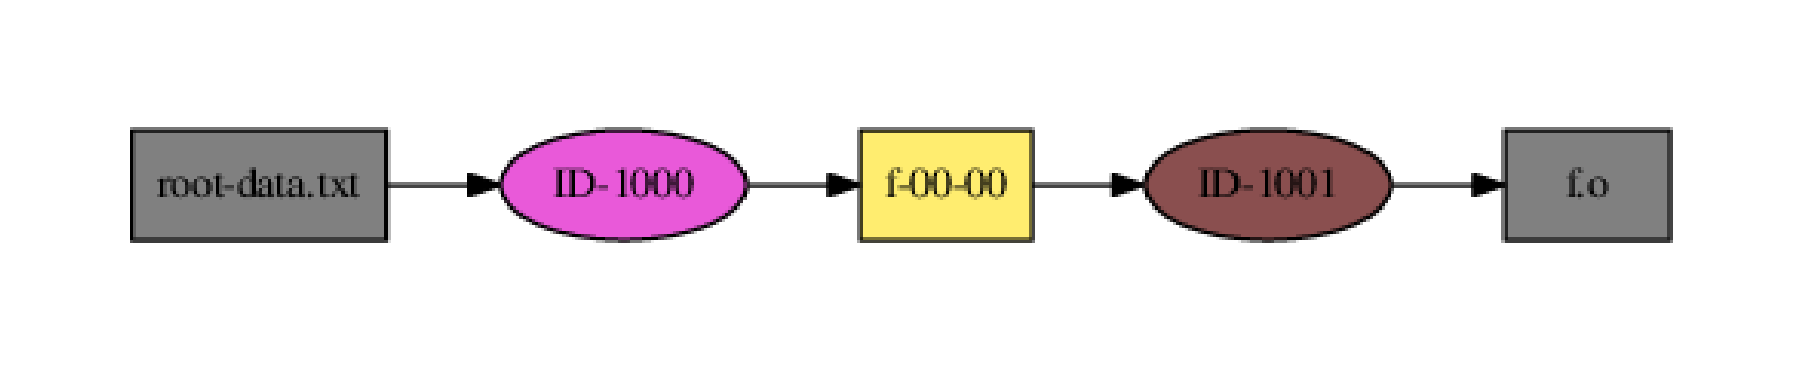

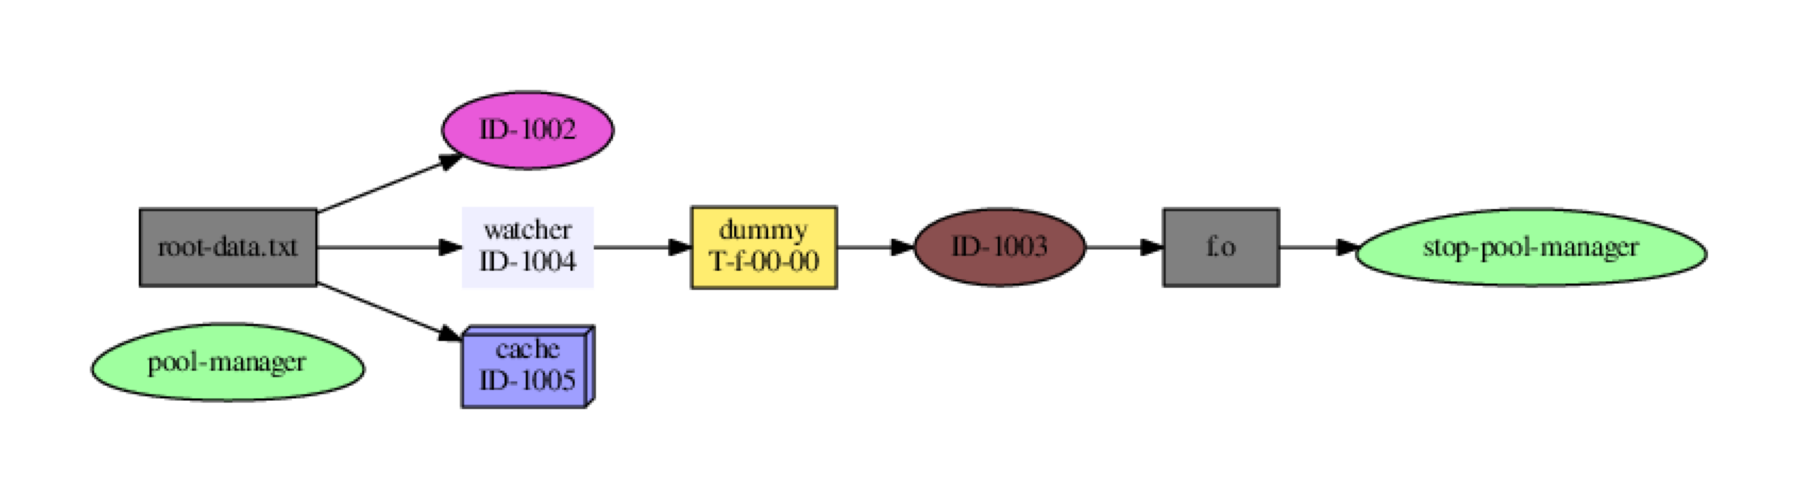

In [11]:
# ---------------------------------------
# cdo_dependencies : false, CDOs are not matched between in/out so CDO consumers do not depend on producers, the DAG is split
#                  : true, CDOs behave like files and trigger dependencies
# display_files : true, files appear as nodes in the graph, otherwise not
# transitive_reduction : true - remove links that are superfluous - transitive, between job-job bypassing files

# cdo_dependencies must be False when executing a CDO enabled workflow

cdo_dependencies     = False
display_files        = True
transitive_reduction = True
left_right           = True

global_component_id = 1000

if os.path.isfile("pegasus.properties"):
    os.remove("pegasus.properties")
if os.path.isfile("sites.yml"):
    os.remove("sites.yml")

rco = ReplicaCatalog()
rcm = ReplicaCatalog()
sco = build_site_catalog()    
prp = build_properties()

# ---------------------------------------
# Generate workflows, one original, one maestro enabled
wfo = Workflow(name="demo-orig.yml")
wfm = Maestro_Workflow(cdo_dependencies, name="demo-maestro.yml", infer_dependencies=False)

build_transformation_catalog(wfo)
build_transformation_catalog(wfm)
    
# ---------------------------------------
# Convert workflow into nice DAG display
iterations = 0
forks = 1
subforks = 1
file1 = generate_demo_workflow(wfo, rco, iterations=iterations, forks=forks, subforks=subforks)
I1 = display_workflow(file1, transitive_reduction, display_files, left_right)

file2 = generate_demo_workflow(wfm, rcm, maestro=True, iterations=iterations, forks=forks, subforks=subforks)
I2 = display_workflow(file2, transitive_reduction, display_files, left_right ) # left_right and cdo_dependencies)


# ---------------------------------------
# rename pdf files based on what options we used to generate the DAG pics
fstring  = "-cdo" if cdo_dependencies else ""
fstring += "-files" if display_files else ""
fstring += "-reduced" if transitive_reduction else ""
image_name1 = I1.replace('.dot.pdf', fstring + '.pdf')
image_name2 = I2.replace('.dot.pdf', fstring + '.pdf')
os.rename(I1, image_name1)
os.rename(I2, image_name2)

# ---------------------------------------
# read+convert PDFs into images
img_A = WImage(filename=image_name1)
img_B = WImage(filename=image_name2)

# ---------------------------------------
# figure size in inches optional
rcParams['figure.figsize'] = 32, 32
# ---------------------------------------
# display images in notebook
fig, ax = plt.subplots(1,1)
ax.imshow(img_A);
ax.set_axis_off()
fig, ax = plt.subplots(1,1)
ax.imshow(img_B);
ax.set_axis_off()

In [12]:
wfm.execute_using_splinter()


Poll loop 0  : Completed tasks []  : Pending tasks ['ID0000001', 'ID0000002', 'ID0000003', 'ID0000004', 'ID0000005', 'ID0000006']
Submitting Job ID0000001 ['/home/scitech/shared-data/maestro-test/binaries/start-pool-manager.sh', '/home/scitech/scratch/', 'pool_manager.stop', '/home/scitech/mocktage/build/bin//pool_manager', '/home/scitech/scratch//pminfo']
Submitting Job ID0000002 ['/home/scitech/mocktage/build/bin/process-CDO', '-l', '/home/scitech/scratch/', '-p', 'pminfo', '-c', 'ID-1002', '-o', 'f-00-00', '-O', '2']
Submitting Job ID0000004 ['/home/scitech/mocktage/build/bin/process-CDO', '-l', '/home/scitech/scratch/', '-p', 'pminfo', '-t', 'T-f-00-00', '-c', 'ID-1004', '-i', 'f-00-00']
Submitting Job ID0000005 ['/home/scitech/mocktage/build/bin/process-CDO', '-l', '/home/scitech/scratch/', '-p', 'pminfo', '-c', 'ID-1005', '-g', '-i', 'f-00-00', '-O', '1']

Poll loop 1  : Completed tasks []  : Pending tasks ['ID0000003', 'ID0000006']

Poll loop 2  : Completed tasks []  : Pending 

In [13]:
#wfo.plan(submit=True, sites=['condorpool'], cleanup=False)\
# wfm.plan(submit=True, cleanup=False, sites=["condorpool"],verbose=0)\
#     .wait()\
#     .analyze()\
#     .statistics()

In [14]:
#wfm.halt()